In [1]:
from sklearn.linear_model import LogisticRegression
from IPython.display import HTML
from tqdm import tqdm_notebook
import sys; sys.path.append('paper')
from initialize import * # user settings: feel free to change

data, scaler = load_data() # helper function to load in a dictionary containing our dataset.
data['X'].head()

,Married,Single,Age_lt_25,Age_in_25_to_40,Age_in_40_to_59,...,MostRecentBillAmount,MostRecentPaymentAmount,TotalOverdueCounts,TotalMonthsOverdue,HistoryOfOverduePayments
0,1,0,1,0,0,...,120,0,1,4,1
1,0,1,0,1,0,...,80,0,2,4,1
2,0,1,0,1,0,...,890,50,0,0,0
3,1,0,0,1,0,...,1430,60,0,0,0
4,1,0,0,0,1,...,260,60,0,0,0


# Set up our Actionset

In [2]:
# action set
default_bounds = (1.0, 99.0, 'percentile')
custom_bounds = None
immutable_variables = []
if settings['data_name'] == 'credit':
    ## set features in our input data that are immutable: 
    ##     i.e. individuals will not be asked to change any of these 
    ##          variables when the optimizer seeks recourse.
    immutable_names = ['Female', 'Single', 'Married']
    immutable_names += list(filter(lambda x: 'Age' in x or 'Overdue' in x, data['variable_names']))
    data['immutable_variable_names'] = [n for n in immutable_names if n in data['variable_names']]

    ## set the default and custom bounds we wish to search over.
    default_bounds = (0.1, 99.9, 'percentile')
    custom_bounds = {'Female': (0, 100, 'p'),  'Married': (0, 100, 'p')}
    
    ## 
    action_set = ActionSet(X = data['X'], custom_bounds = custom_bounds, default_bounds = default_bounds)
    action_set[data['immutable_variable_names']].mutable = False

    ## set other custom behaviors in each of the data types.
    action_set['EducationLevel'].step_direction = 1
    payment_fields = list(filter(lambda x: 'Amount' in x, data['variable_names']))
    action_set[payment_fields].step_type = 'absolute'
    action_set[payment_fields].step_size = 50

    for p in payment_fields:
        action_set[p].update_grid()

# Generate a Flipset

In [4]:
clf = (
    LogisticRegression(C=.02, max_iter=1000, penalty='l1', solver='saga', tol=1e-8)
       .fit(data['X_train'], data['y'])
)

In [ ]:
### Create Flipset
yhat = clf.predict(X = data['X_train'])
coefficients, intercept = undo_coefficient_scaling(clf, scaler = data['scaler'])
action_set.align(coefficients)
predicted_neg = np.flatnonzero(yhat < 1)
U = data['X'].iloc[predicted_neg].values

## 
k = 4
fb = Flipset(x = U[k], action_set = action_set, coefficients = coefficients, intercept = intercept)
fb.populate(enumeration_type = 'distinct_subsets', total_items = 14)

In [7]:
from IPython.display import HTML
HTML(fb.to_html())

# Train classifiers

In [29]:
from copy import deepcopy as copy

In [36]:
from sklearn.model_selection import StratifiedKFold as CVGenerator
from sklearn.model_selection import GridSearchCV
cv_generator = CVGenerator(n_splits = 10, random_state = settings['randomseed'])

# this code is for general purpose train/test evaluation using GridSearchCV
gridsearch = GridSearchCV(
    clf, param_grid={"C":[1.0 / l for l in [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]]},
    scoring='neg_mean_squared_error',
    return_train_score=True,
    cv=cv_generator,
    verbose=1,
    n_jobs=-1
)

if settings['normalize_data']:
    gridsearch.fit(data['X_scaled'], data['y'])
else:
    gridsearch.fit(data['X'], data['y'])
grid_search_df = pd.DataFrame(gridsearch.cv_results_)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.1min finished


In [37]:
# cache a model for each parameter combination, trained on all data
model_dict = {}
grid_search_df['key'] = pd.np.nan
for idx, p in tqdm_notebook(list(grid_search_df.params.iteritems())):
    if settings['normalize_data']:
        model = copy(clf.set_params(**p)).fit(data['X_scaled'], data['y'])
    else:
        model = copy(clf.set_params(**p)).fit(data['X'], data['y'])

    key = '__'.join(map(lambda x: '%s_%s' % x, p.items()))
    model_dict[key] = model
    grid_search_df.loc[idx, 'key'] = key

In [50]:
model_stats_df = refomat_gridsearch_df(
    grid_search_df,
    settings=settings,
    n_coefficients = data['X'].shape[1],
    invert_C=settings['method_name'] == 'logreg'
)

# Run Audit

In [38]:
audit_results = {}
for key, clf in model_dict.items():
    if settings['method_name'] == 'logreg':
        model_name = 1. / float(key.split('_')[1])
    else:
        model_name = float(key.split('_')[1])
        
    # unscale coefficients
    if scaler is not None:
        coefficients, intercept = undo_coefficient_scaling(coefficients = np.array(clf.coef_).flatten(), intercept = clf.intercept_[0], scaler = scaler)
    else:
        coefficients, intercept = np.array(clf.coef_).flatten(), clf.intercept_[0]

    ## run audit
    print("Auditing for model %s..." % key)
    auditor = RecourseAuditor(
        action_set,
        coefficients = coefficients,
        intercept = intercept
    )
    audit_results[model_name] = auditor.audit(X = data['X'])


## cache
if settings['save_flag']:
    pickle.dump(audit_results, file = open(settings['audit_file'], 'wb'), protocol=2)

Auditing for model C_1.0...


Auditing for model C_0.5...


Auditing for model C_0.2...


Auditing for model C_0.1...


Auditing for model C_0.05...


Auditing for model C_0.02...


Auditing for model C_0.01...


Auditing for model C_0.005...


Auditing for model C_0.002...


Auditing for model C_0.001...


# Plots

In [39]:
save_figs = False

## Error plot path for models (Figure 2, top left)

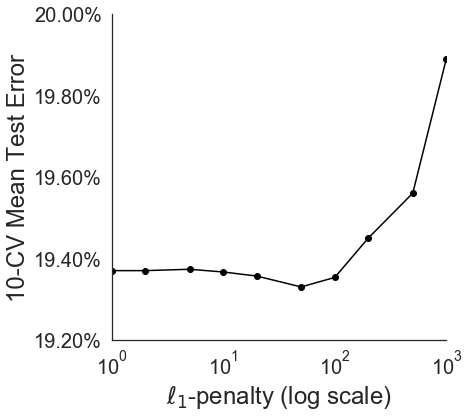

In [56]:
## plotting performance vs. l1 penalty
train_error = model_stats_df.groupby('param 0: C')['train_score'].aggregate(['mean', 'var'])
test_error = model_stats_df.groupby('param 0: C')['test_score'].aggregate(['mean', 'var'])

ax = test_error.pipe(lambda df:
    (-df['mean']).plot(label='test error', color='black', figsize=(6, 6))
)
ax.errorbar(test_error.index, -test_error['mean'], yerr=test_error['var'], fmt='o', color='black')
ax.set_facecolor('white')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# formatting
y_ticks = list(plt.yticks()[0])
y_tick_labels = list(map(lambda x: '%.02f' % (x * 100) + '%', y_ticks))
plt.semilogx(basex=10)
plt.yticks(y_ticks[::2], y_tick_labels[::2])
#
ax.set_ylabel('10-CV Mean Test Error')
ax.set_xlabel(xlabel)
if save_figs:
    plt.savefig('%s_error_path.pdf' % settings['file_header'], bbox_inches='tight')
    plt.close()

## Number of Non-zero Coefficients (Figure 2, top-right)

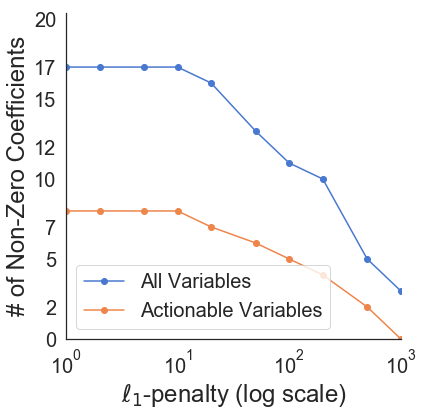

In [16]:
# plotting # of coefficients vs. l1 penalty...
# get binary counts and sums
coef_df = get_coefficient_df(all_models, variable_names = data['X'].columns.tolist())
nnz_coef_df = (coef_df
    .apply(lambda x: ~np.isclose(x, 0, atol=5e-3))
)
# cache how many features are nonzero for each classifier
non_zero_sum = nnz_coef_df.sum().rename(lambda x: 1./float(x.split('_')[1]))
non_zero_sum_actionable = (nnz_coef_df
                           .pipe(lambda df: df.loc[~df.index.isin(immutable_names)])
                           .sum()
                           ).rename(lambda x: 1./float(x.split('_')[1]))

# plot # of non zero coefficients
ax = non_zero_sum.plot(marker='o', label = 'All Variables', figsize=(6, 6))
ax = non_zero_sum_actionable.plot(ax= ax, marker='o', label='Actionable Variables')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.semilogx()
ax.set_yticks(list(map(int, ax.get_yticks())))
ax.set_facecolor('white')
ax.set_xlabel(xlabel)
ax.set_ylim((0, max(non_zero_sum.max(), non_zero_sum_actionable.max())*1.2))
ax.set_ylabel('# of Non-Zero Coefficients')
ax.legend(frameon = True)
if save_figs:
    f.savefig('%s_regularization_path.pdf' % settings['file_header'])
    plt.close()

## % Individuals without Recourse (Figure 2, bottom left)

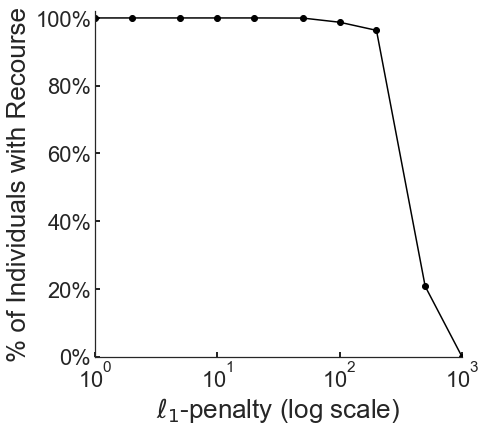

In [12]:
if settings['method_name'] == 'logreg':
    xlabel = '$\ell_1$-penalty (log scale)'
else:
    xlabel = '$C$-penalty (log scale)'
# percent of points without recourse
feasibility_df = {}
obj_val = {}

for model_name in sorted(audit_results):
    recourse_df = pd.DataFrame(audit_results[model_name])
    recourse_cost = recourse_df.loc[lambda df: df.feasible.notnull()].loc[:, 'cost']
    feasibility_df[model_name] = recourse_df['feasible'].mean()
    obj_val[model_name] = recourse_cost.mean()

# feasibility plot
f, ax = create_figure(fig_size = (6, 6))
t_found = pd.Series(feasibility_df)
t_found.plot(ax = ax, color = 'black', marker='o')
plt.semilogx()
ax.set_xlabel(xlabel)
ax.set_ylabel('% of Individuals with Recourse')
ax.set_ylim(0, 1.02)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals = 0))
ax = fix_font_sizes(ax)
if save_figs:
    f.savefig('%s_recourse_feasibility.pdf' % settings['audit_file_header'], bbox_inches = 'tight')

## Cost of Recourse (Figure 2, bottom right)

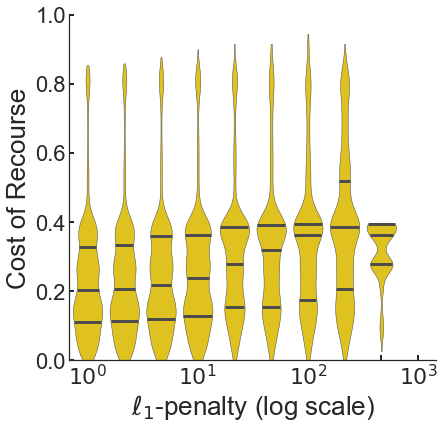

In [13]:
cost_df = {k: pd.DataFrame(v) for k, v in audit_results.items()}
cost_df = pd.concat([cost_df[k]['cost'].to_frame('%f' % k) for k in sorted(cost_df.keys())], axis=1).replace([-np.inf, np.inf], np.nan)

# plot cost distribution
f, ax = create_figure(fig_size = (6, 6))
sns.violinplot(data = cost_df, ax = ax, linewidth = 0.5, cut = 0, inner = 'quartile', color = "gold", scale = 'width')
ax.set_xlabel(xlabel)
ax.set_ylabel('Cost of Recourse')
ax.set_ylim(bottom = 0, top = 1)
xtick_labels = []
for xt in ax.get_xticklabels():
    v = np.log10(float(xt.get_text()))
    label = '$10^{%.0f}$' % v if v == np.round(v, 0) else ' '
    xtick_labels.append(label)
ax.set_xticklabels(xtick_labels)

for l in ax.lines:
    l.set_linewidth(3.0)
    l.set_linestyle('-')
    l.set_solid_capstyle('butt')

ax = fix_font_sizes(ax)
if save_figs:
    f.savefig('%s_recourse_cost_distribution.pdf' % settings['audit_file_header'], bbox_inches = 'tight')
    plt.close()